## Modified Ornstein Uhlenbeck Process for Simulating Temperature Paths (De-seasoned temperature series follows an AR(3) process)
### David Islip

In [127]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
from scipy.stats import norm
import numpy as np
import math
import seaborn as sns
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
import statsmodels.api as sm
import statsmodels.tsa.ar_model as ar_model
import statsmodels
from statsmodels.graphics.api import qqplot
import pickle
%matplotlib inline

### 0. The model:
The model that will be used to simulate temperature paths is as in Benth et al. Essentially the model is a discretizination of a ornstein uhlenbeck SDE with a linear - periodic mean function and a periodic volatility function:

$dT(t) = ds(t) - \kappa(T(t) - s(t))dt + \sigma(t)dB(t)$

where 

$s(t) = a + bt + \sum_ia_isin(2\pi it/365) + \sum_jb_jcos(2\pi jt/365)$

and

$\sigma^2(t) = a + \sum_ic_isin(2\pi it/365) + \sum_jd_jcos(2\pi jt/365)$


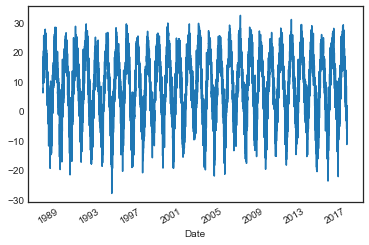

In [128]:
T = pd.read_csv("CleanedTemperature.csv")
T.rename(columns={T.columns[0]: 'Date'}, inplace=True)
T.index = pd.to_datetime(T["Date"])
T.drop(T.index[T.index.dayofyear == 366],axis=0, inplace = True)
T.drop("Date", axis = 1, inplace = True)
#T.plot(subplots = True, fontsize = 8,layout = (4,3))
T["Buttonville A"].plot()

### 1. Regression to obtain $m(t)$

In [129]:
Y = np.array(T)
#generating the factor space for the mean
a = np.ones(len(Y))
t = np.linspace(1,len(Y),len(Y))
N = 4 #number of sine and cosine functions to include
n = np.linspace(1,N,N)
Sines = np.sin(2*np.pi*(np.outer(t,n))/365)
Cosines = np.cos(2*np.pi*(np.outer(t,n))/365)
X = np.stack((a, t), axis=1)
X = np.concatenate((X,Sines,Cosines),axis=1)
## making sure the columns are readable
cols = ['Constant', 'time']
for i in range(N):
    cols.append('sin(2pi*'+str(i+1)+'t/365)')
for i in range(N):
    cols.append('cos(2pi*'+str(i+1)+'t/365)')
X = pd.DataFrame(X,columns = cols)

#### 1.1 Using Lasso Regression to shrink factors to zero
The plot below varies the magnitude of the lasso regularization to see which parameters go to zero

Training data:  $(x_t,y_t)$

Model Specification: $Y = \beta X + C$

Lasso regularization: $\underset{\beta}{\operatorname{argmin}}\sum_t(y_t - (\beta x_t + C))^2 + \lambda||\beta||_{l1} $

Depending on the value of $\lambda$, the coefficients in beta will shrink to zero

In [130]:
Y = np.transpose(Y)
y = Y[0][:]
L = []
model = sm.OLS(y, X)
for i in range(10):
    results = model.fit_regularized(method = 'elastic_net',alpha=i/10, L1_wt=0.5)
    L.append(results.params)

,Constant,time,sin(2pi*1t/365),sin(2pi*2t/365),sin(2pi*3t/365),sin(2pi*4t/365),cos(2pi*1t/365),cos(2pi*2t/365),cos(2pi*3t/365),cos(2pi*4t/365)
0,1.000000,0.160784,1.000000,1.000000,-inf,-inf,1.000000,1.000000,1.000000,-inf
1,0.812745,0.377072,0.902925,0.602671,-inf,NaN,0.855326,0.586144,0.518852,-inf
2,0.678679,0.532015,0.821889,0.269122,-inf,NaN,0.733345,0.250372,0.121704,NaN
3,0.577889,0.648549,0.753255,0.000000,-inf,NaN,0.629158,0.000000,0.000000,NaN
4,0.499327,0.739326,0.694433,0.000000,NaN,NaN,0.539177,0.000000,0.000000,NaN
5,0.436380,0.812065,0.643425,0.000000,NaN,NaN,0.460863,0.000000,0.000000,NaN
6,0.384778,0.871713,0.598767,0.000000,NaN,NaN,0.392003,0.000000,0.000000,NaN
7,0.341700,0.921522,0.559346,0.000000,NaN,NaN,0.330994,0.000000,0.000000,NaN
8,0.305190,0.963746,0.524292,0.000000,NaN,NaN,0.276575,0.000000,0.000000,NaN
9,0.273851,1.000000,0.492919,0.000000,NaN,NaN,0.227737,0.000000,0.000000,NaN


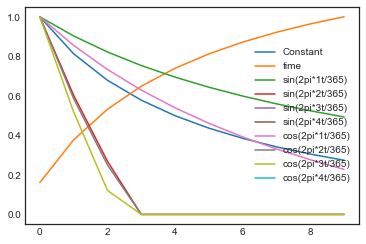

In [131]:
L = pd.DataFrame(L)
L = L/L.max(axis=0)
L.plot()
L

In [132]:
cols = L.columns[L.iloc[len(L)-1] > 0.001]
Xs = X[cols]

#### 1.2 Mean Regression Results (p-values, coefficients .... )

In [133]:
model = sm.OLS(y,Xs)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 1.703e+04
Date:                Sun, 21 Jan 2018   Prob (F-statistic):               0.00
Time:                        15:24:46   Log-Likelihood:                -31659.
No. Observations:               10831   AIC:                         6.333e+04
Df Residuals:                   10827   BIC:                         6.336e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Constant            7.1862      0.087     

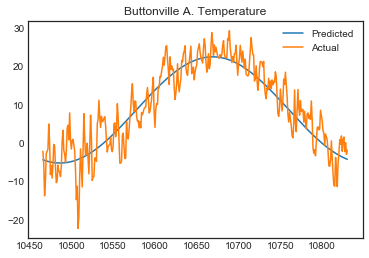

In [134]:
Comparison = pd.DataFrame(results.predict(Xs))
Comparison["Actual"] = y
Comparison.rename(columns={Comparison.columns[0]: 'Predicted'}, inplace=True)
Comparison.iloc[len(y)-365:len(y)].plot(title = "Buttonville A. Temperature")

### 2. AR(k) Process for the Residuals


Discretizing the SDE implies that the mean removed temperature series follows an AR(k) process

$X_{t}= \sum_{j=1}^k\alpha_j X_{t-j} + \sigma (t)\epsilon$

#### 2.1 The code below is motivation for an AR(k) process for the residuals obtained from above: we see that there is significant correlation among the residuals from the mean process

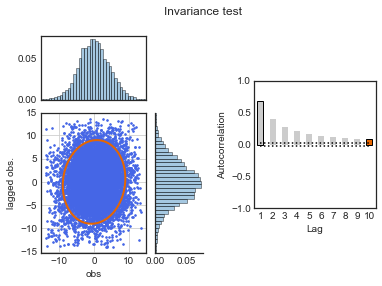

In [135]:
epsi = Comparison['Actual'] - Comparison['Predicted']
epsi = np.array(epsi)
epsi = np.expand_dims(epsi, axis=0)

lag_ = 10  # number of lags (for auto correlation test)
acf = autocorrelation(epsi, lag_)

lag = 10 # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting
InvarianceTestEllipsoid(epsi, acf[0,1:], lag, fit, ell_scale);

In [136]:
epsi = Comparison['Actual'] - Comparison['Predicted']
epsi = np.array(epsi)
model = sm.tsa.AR(epsi)
AResults= model.fit(maxlag = 30, ic = "bic",method = 'cmle')
print("The maximum number of required lags for the residuals above according to the Bayes Information Criterion is:")
n_lags = sm.tsa.AR(epsi).select_order(maxlag = 10, ic = 'bic',method='cmle')
n_lags

The maximum number of required lags for the residuals above according to the Bayes Information Criterion is:


3

AR(k) params
[ 0.80464982 -0.23949133  0.11828659]
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                10831
Model:                     ARMA(3, 0)   Log Likelihood              -28009.939
Method:                       css-mle   S.D. of innovations              3.213
Date:                Sun, 21 Jan 2018   AIC                          56027.878
Time:                        15:24:49   BIC                          56057.039
Sample:                             0   HQIC                         56037.710
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.8046      0.010     84.337      0.000       0.786       0.823
ar.L2.y       -0.2395      0.012    -19.853      0.000      -0.263      -0.216
a

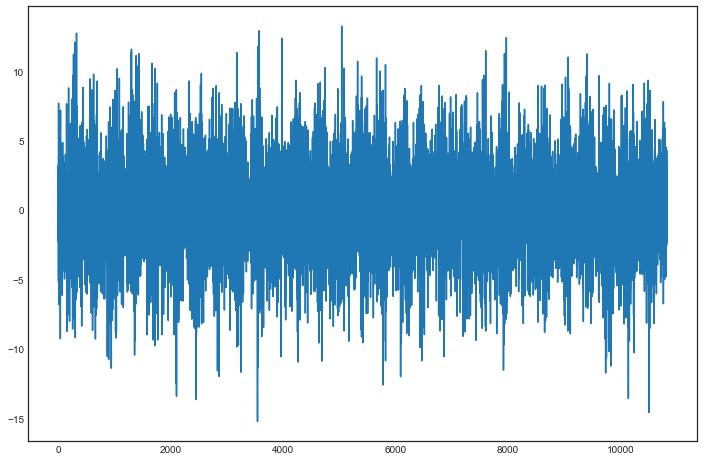

In [137]:
arma_mod = sm.tsa.ARMA(epsi, (n_lags,0)).fit(trend='nc',disp=False)
print("AR(k) params")
print(arma_mod.params)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = plt.plot(arma_mod.resid);

print(arma_mod.summary())

#### 2.2 Invariance check for the residuals of the AR(1) process

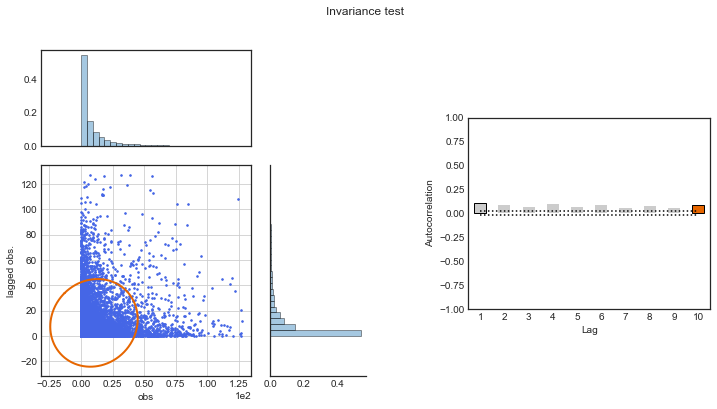

In [150]:
z = np.expand_dims(arma_mod.resid, axis=0)

fig = plt.figure(figsize=(12,6))
lag_ = 10  # number of lags (for auto correlation test)
acf = autocorrelation(z**2, lag_)

lag = 10  # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting

InvarianceTestEllipsoid(z**2, acf[0,1:], lag, fit, ell_scale);

#### 2.3 As per Benth lets see what the residuals of the AR(1) process are doing...

(10831, 10)

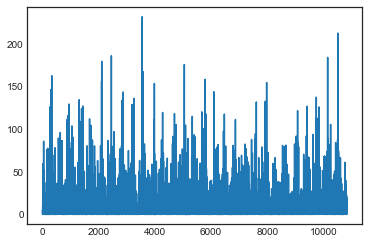

In [139]:
z = arma_mod.resid
plt.plot(z**2)
z.shape
X.shape

### 3. Modelling the Volatility Term: $\sigma^2(t) $

In [140]:
sigma = z**2
L = []
volmodel = sm.OLS(sigma, X)
for i in range(10):
    volresults = volmodel.fit_regularized(method = 'elastic_net',alpha=i/10, L1_wt=0.5)
    L.append(volresults.params)

,Constant,time,sin(2pi*1t/365),sin(2pi*2t/365),sin(2pi*3t/365),sin(2pi*4t/365),cos(2pi*1t/365),cos(2pi*2t/365),cos(2pi*3t/365),cos(2pi*4t/365)
0,1.000000,-0.225206,2.300815,-inf,1.000000,-inf,1.0,6.939246,1.0,-inf
1,0.818227,0.093036,2.046669,NaN,0.846782,NaN,0.0,5.802291,0.0,-inf
2,0.688486,0.320238,1.837069,NaN,0.716656,NaN,0.0,4.850213,0.0,-inf
3,0.591247,0.490441,1.660788,NaN,0.605370,NaN,0.0,4.044124,0.0,NaN
4,0.515657,0.622712,1.510400,NaN,0.509482,NaN,0.0,3.353818,0.0,NaN
5,0.455211,0.728454,1.380538,NaN,0.426086,NaN,0.0,2.756251,0.0,NaN
6,0.405775,0.814915,1.267239,NaN,0.352927,NaN,0.0,2.234023,0.0,NaN
7,0.364593,0.886925,1.167507,NaN,0.288252,NaN,0.0,1.773796,0.0,NaN
8,0.329758,0.947825,1.079031,NaN,0.230680,NaN,0.0,1.365187,0.0,NaN
9,0.299908,1.000000,1.000000,NaN,0.179110,NaN,0.0,1.000000,0.0,NaN


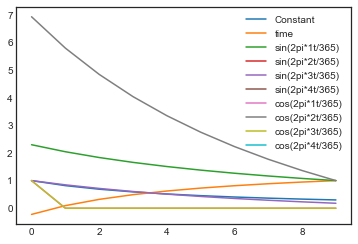

In [141]:
L = pd.DataFrame(L)
L = L/L.max(axis=0)
L.plot()
L

In [142]:
volcols = L.columns[L.iloc[len(L)-1] > 0.001]
Xvol = X[volcols]
volmodel = sm.OLS(sigma,Xvol)
VolResults = volmodel.fit()
print(VolResults.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     172.6
Date:                Sun, 21 Jan 2018   Prob (F-statistic):          1.65e-143
Time:                        15:24:54   Log-Likelihood:                -45923.
No. Observations:               10831   AIC:                         9.186e+04
Df Residuals:                   10826   BIC:                         9.189e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Constant           11.4725      0.323     

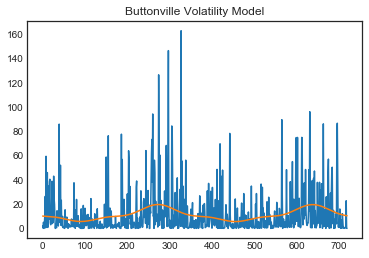

In [143]:
VolComparison = pd.DataFrame(VolResults.predict())
VolComparison["Actual"] = sigma
VolComparison.rename(columns={VolComparison.columns[0]: 'Predicted'}, inplace=True)
VolComparison.iloc[0:720]['Actual'].plot(title = "Hamilton Volatility Model")
VolComparison.iloc[0:720]['Predicted'].plot(title = "Buttonville Volatility Model")

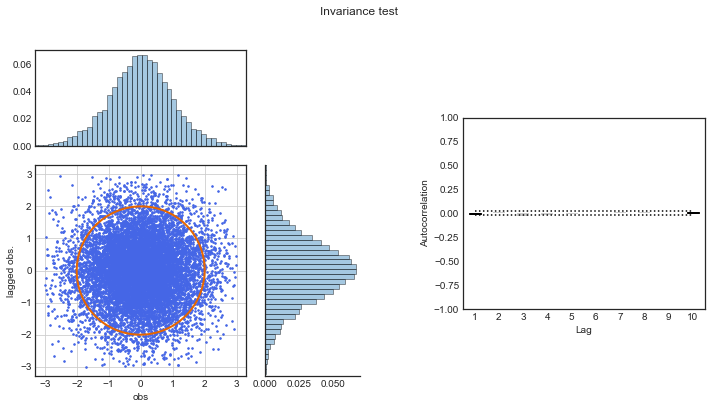

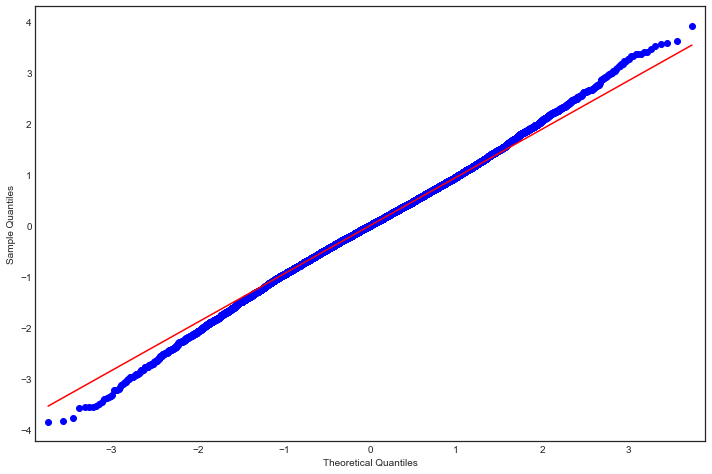

In [144]:
inv = z/(VolResults.predict())**0.5
inv = np.expand_dims(inv, axis=0)
fig = plt.figure(figsize=(12,6))
lag_ = 10  # number of lags (for auto correlation test)
acf = autocorrelation(inv, lag_)

lag = 10  # lag to be printed
ell_scale = 2  # ellipsoid radius coefficient
fit = 0  # normal fitting
InvarianceTestEllipsoid(inv, acf[0,1:], lag, fit, ell_scale);

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(inv[0], line='q', ax=ax, fit=True)

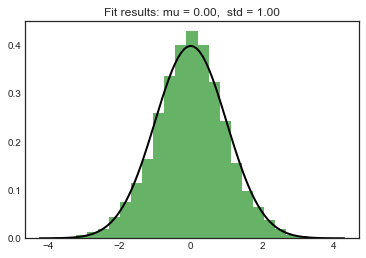

In [145]:
# Fit a normal distribution to the data:
mu, std = norm.fit(inv[0])

# Plot the histogram.
plt.hist(inv[0], bins=25, normed=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

### 4. Monte Carlo Simulation

In [146]:
#tau is the risk horizon
tau = 365*2

a = np.ones(tau)
t = np.linspace(len(y),len(y)+tau,tau)
N = 4 #number of sine and cosine functions to include
n = np.linspace(1,N,N)
Sines = np.sin(2*np.pi*(np.outer(t,n))/365)
Cosines = np.cos(2*np.pi*(np.outer(t,n))/365)
X_proj = np.stack((a, t), axis=1)
X_proj = np.concatenate((X_proj,Sines,Cosines),axis=1)
temp_cols = ['Constant', 'time']
for i in range(N):
    temp_cols.append('sin(2pi*'+str(i+1)+'t/365)')
for i in range(N):
    temp_cols.append('cos(2pi*'+str(i+1)+'t/365)')
X_proj = pd.DataFrame(X_proj,columns = temp_cols)

In [147]:
b = X_proj[cols]
results.predict(b);

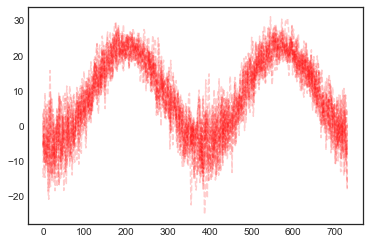

In [148]:
#M is the number of monte carlo paths to simulate
M = 10000
lag_params = np.array(arma_mod.params)

invariants  = np.random.normal(0, 1, (tau,M))

vol_proj = (VolResults.predict(X_proj[volcols]))**0.5

sig_hat = np.expand_dims(vol_proj, axis=1)*invariants

AR = np.zeros([tau+n_lags,M])

AR[0:n_lags,:] = np.outer(epsi[-n_lags:],np.ones([1,M]))
for i in range(tau):
    AR[i+n_lags,:] = np.dot(lag_params[::-1],AR[i:n_lags+i,:])+ sig_hat[i]
    
x_proj = X_proj[cols]
Mean_Temp = np.expand_dims(results.predict(x_proj ),axis=1)

Temp_Paths = np.repeat(Mean_Temp,M,axis=1)+ AR[n_lags:,:]

plt.plot(Temp_Paths[:,0:10],'r--',alpha = 0.2);

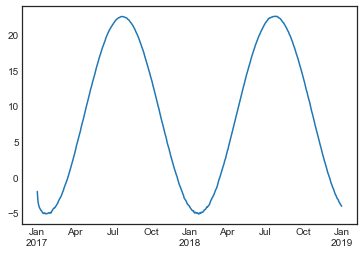

In [149]:
T_innov = pd.DataFrame(invariants)
T_out = pd.DataFrame(Temp_Paths)
T_out.index = np.arange(T.index[-1],T.index[-1] + dt.timedelta(tau),dt.timedelta(days=1)).astype(dt.datetime)
T_innov.index = T_out.index
#T_out.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tout.pkl")
#T_innov.to_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tinnov.pkl")
T_out.mean(axis = 1).plot()
T_out["model#"] = 3